In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
#function to climatology and anomaly for given variable
def component_fn(inp):
    bar = inp.mean('time')
    #clim = inp.groupby('time.month').mean('time')
    dash = inp - bar
    return bar, dash

In [3]:
def diff_T(T):
    dTdt = T.differentiate(coord = 'time',datetime_unit= 's')
    dTdx = T.differentiate('lon') / (110e3 * np.cos(T.lat * np.pi / 180))
    dTdy = T.differentiate('lat') / (110e3 )
    dTdz = (T[:,0] - T[:,-1])/float(T.level[-1])
    return dTdt[:,:-1], dTdx[:,:-1], dTdy[:,:-1], dTdz



def get_weights(INP):
    weights = INP.level
    #add a 0m surface layer
    wt=np.array([0.])
    for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
    thickness = wt[1:]-wt[:-1]
    thickness_DA = xr.DataArray(thickness, coords={'level': INP.level},
                 dims=['level'])
    return thickness_DA

def weighted_avg(inp, weights):
    avg=inp.weighted(weights).mean('level')
    return avg


def get_clim(dict_name):
    dict1={}
    #unpack dict, get climatology, repack
    for key in dict_name.keys():
        var = dict_name[key]
        var = var.groupby('time.month').mean('time')
        dict1[key] = var
    return dict1

In [4]:
#now do the same for ec-earth3
T = xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/pottmp/*.nc').pottmp
U = xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/ucur/*.nc').ucur
V = xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/vcur/*.nc').vcur
W = xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/dzdt/*.nc').dzdt
#get only to 50m
T = T[:,:5]
U = U[:,:5]
V = V[:,:5]
W = W[:,4]
#now put lat lon of uvw to T
U = U.assign_coords({'lat': T.lat, 'lon': T.lon})
V = V.assign_coords({'lat': T.lat, 'lon': T.lon})
W = W.assign_coords({'lat': T.lat, 'lon': T.lon})
#rename lev coord to level
#T = T.rename({'lev':'level'})
#U = U.rename({'lev':'level'})
#V = V.rename({'lev':'level'})
#W = W.rename({'lev':'level'})

In [5]:
T

,Array,Chunk
Bytes,637.63 MB,15.55 MB
Shape,"(492, 5, 180, 360)","(12, 5, 180, 360)"
Count,164 Tasks,41 Chunks
Type,float32,numpy.ndarray


In [6]:
dTdt, dTdx, dTdy, dTdz = diff_T(T)

In [7]:
#calcualte components for dT
dxc, dxd = component_fn(dTdx)
dyc, dyd = component_fn(dTdy)
dzc, dzd = component_fn(dTdz)

In [8]:
dxc

<xarray.DataArray (level: 4, lat: 180, lon: 360)>
dask.array<mean_agg-aggregate, shape=(4, 180, 360), dtype=float32, chunksize=(4, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * level    (level) float32 5.0 15.0 25.0 35.0

In [9]:
dxd

,Array,Chunk
Bytes,510.11 MB,12.44 MB
Shape,"(492, 4, 180, 360)","(12, 4, 180, 360)"
Count,591 Tasks,41 Chunks
Type,float32,numpy.ndarray


In [10]:
dxd

,Array,Chunk
Bytes,510.11 MB,12.44 MB
Shape,"(492, 4, 180, 360)","(12, 4, 180, 360)"
Count,591 Tasks,41 Chunks
Type,float32,numpy.ndarray


In [14]:
(dxd*dxc).groupby('time.month').mean('time')

<xarray.DataArray (month: 12, level: 4, lat: 180, lon: 360)>
dask.array<stack, shape=(12, 4, 180, 360), dtype=float32, chunksize=(1, 4, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * level    (level) float32 5.0 15.0 25.0 35.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [15]:
dxc*dxd

,Array,Chunk
Bytes,510.11 MB,12.44 MB
Shape,"(4, 180, 360, 492)","(4, 180, 360, 12)"
Count,674 Tasks,41 Chunks
Type,float32,numpy.ndarray


In [16]:
#calculate compenets of u,v,w
uc, ud = component_fn(U)
vc, vd = component_fn(V)
wc, wd = component_fn(W)

In [17]:
dxd*uc

,Array,Chunk
Bytes,510.11 MB,12.44 MB
Shape,"(492, 4, 180, 360)","(12, 4, 180, 360)"
Count,854 Tasks,41 Chunks
Type,float32,numpy.ndarray


In [18]:
#now calculate 4 terms for each advection term/ Write function here so only need 3 lines for each
def adv_comp(CUR, DT):
    cc, cd = component_fn(CUR)
    dtc, dtz = component_fn(DT)
    ccdtc = cc*dtc
    ccdtz = dtz*cc
    cddtc = cd*dtc
    cddtz = cd*dtz
    return ccdtc, ccdtz, cddtc, cddtz   

In [19]:
ucdxc, ucdxd, uddxc, uddxd = adv_comp(U, dTdx)
vcdyc, vcdyd, vddyc, vddyd = adv_comp(V, dTdy)
wcdzc, wcdzd, wddzc, wddzd = adv_comp(W, dTdz)

In [20]:
#calculate weighted avergae of all terms
weights = get_weights(T)

ucdxc = weighted_avg(ucdxc, weights)
ucdxd = weighted_avg(ucdxd, weights)
uddxc = weighted_avg(uddxc, weights)
uddxd = weighted_avg(uddxd, weights)

vcdyc = weighted_avg(vcdyc, weights)
vcdyd = weighted_avg(vcdyd, weights)
vddyc = weighted_avg(vddyc, weights)
vddyd = weighted_avg(vddyd, weights)

In [27]:
uadv = U*dTdx
uadvw = weighted_avg(uadv, weights)

In [78]:
(uadvw.groupby('time.month').mean('time') -(((ucdxd+uddxd+uddxc).groupby('time.month'))
                                            +ucdxc).groupby('time.month').mean('time')).sel(lat=slice(-40,30),lon=slice(30,125))[0].plot()

ValueError: operands cannot be broadcast together with mismatched lengths for dimension 'month': (12, 144)

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


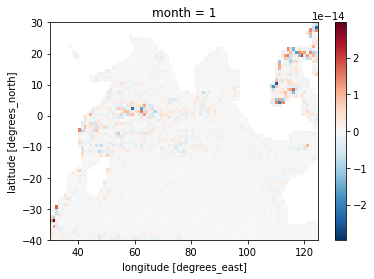

In [73]:
(uadvw.groupby('time.month').mean('time') -(((ucdxd+uddxd+uddxc).groupby('time.month'))
                                            +ucdxc).groupby('time.month').mean('time')).sel(lat=slice(-40,30),lon=slice(30,125))[0].plot()

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


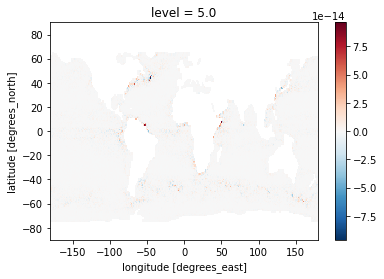

In [45]:
(uc*dxd.groupby('time.month')).mean('time')[0].plot()

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


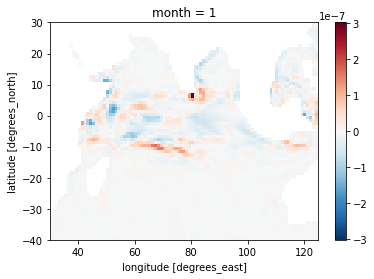

In [87]:
(uadvw.groupby('time.month').mean('time')-((ucdxd+ucdxc+uddxc+uddxd).mean('time'))).sel(lat=slice(-40,30),lon=slice(30,125))[0].plot()

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


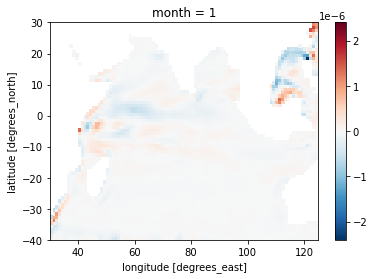

In [85]:
(uadvw.groupby('time.month').mean('time')).sel(lat=slice(-40,30),lon=slice(30,125))[0].plot()

In [21]:
#now get monthly climatology of these terms
ucdxd = ucdxd.groupby('time.month').mean('time')
uddxc = uddxc.groupby('time.month').mean('time')
uddxd = uddxd.groupby('time.month').mean('time')

vcdyd = vcdyd.groupby('time.month').mean('time')
vddyc = vddyc.groupby('time.month').mean('time')
vddyd = vddyd.groupby('time.month').mean('time')

wcdzd = wcdzd.groupby('time.month').mean('time')
wddzc = wddzc.groupby('time.month').mean('time')
wddzd = wddzd.groupby('time.month').mean('time')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


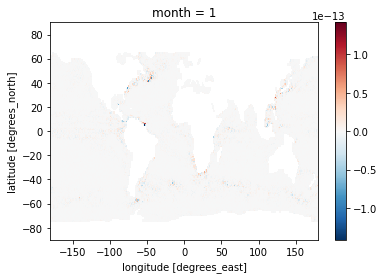

In [17]:
uddxc[0].plot()

In [22]:
#save these datasets
ucdxc.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/seasonal/GODAS_UbTb.nc')
ucdxd.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/seasonal/GODAS_UbTd.nc')
uddxc.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/seasonal/GODAS_UdTb.nc')
uddxd.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/seasonal/GODAS_UdTd.nc')

vcdyc.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/seasonal/GODAS_VbTb.nc')
vcdyd.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/seasonal/GODAS_VbTd.nc')
vddyc.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/seasonal/GODAS_VdTb.nc')
vddyd.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/seasonal/GODAS_VdTd.nc')

wcdzc.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/seasonal/GODAS_WbTb.nc')
wcdzd.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/seasonal/GODAS_WbTd.nc')
wddzc.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/seasonal/GODAS_WdTb.nc')
wddzd.to_netcdf('/home/z5113258/Documents/GODAS/remapcon_1/seasonal/GODAS_WdTd.nc')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


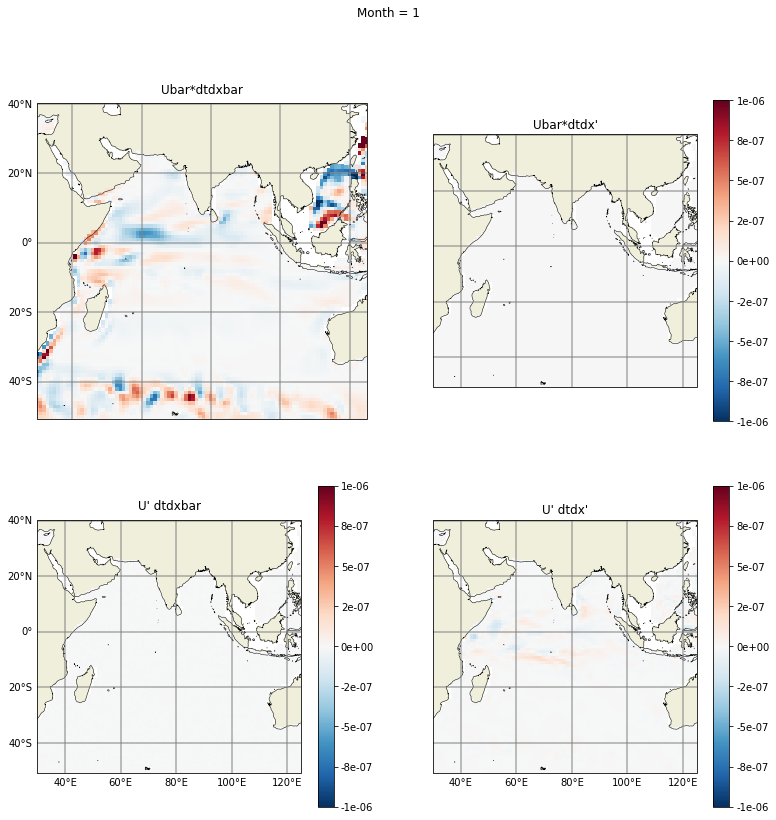

In [19]:
#lets create a plot for each month with each of the 4 advection components
lons = ucdxd.lon
lats = ucdxd.lat
def plot_background(ax, i, j):
    #for use with plotting 12 months. need to change 
    ax.set_extent([30., 125., -40., 30.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.LAND)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5,)
    gl.top_labels = False
    gl.right_labels = False
    if i == 1:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    if j > 0:
        gl.left_labels = False
    return ax
for i in range(0,1):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 13), sharey='all', sharex='all', 
                             subplot_kw={'projection':ccrs.PlateCarree()})
    mon = i+1
    fig.suptitle('Month = '+str(mon))
    #plot  advection term
    axes[0, 0].pcolormesh(lons, lats, ucdxc.sel(month = i+1), cmap = 'RdBu_r', 
                                vmin = -1E-6, vmax = 1E-6, 
                                transform=ccrs.PlateCarree())
    plot_background(axes[0,0], 0, 0)
    axes[0,0].set_title('Ubar*dtdxbar')
    #
    im = axes[0, 1].pcolormesh(lons, lats, ucdxd.sel(month = i+1), cmap = 'RdBu_r', 
                                #colorbar=True, 
                                vmin = -1e-6, vmax = 1e-6, 
                                transform=ccrs.PlateCarree())
    plot_background(axes[0,1], 0, 1)  
    axes[0,1].set_title("Ubar*dtdx'")

    fig.colorbar(im, ax = axes[0,1],format='%.0e')
    #plot difference
    im = axes[1, 0].pcolormesh(lons, lats, uddxc.sel(month = i+1), cmap = 'RdBu_r', 
                                #colorbar=True, 
                                vmin = -1e-6, vmax = 1e-6, 
                                transform=ccrs.PlateCarree())
    plot_background(axes[1, 0], 1, 0)    
    fig.colorbar(im, ax = axes[1,0],format='%.0e')
    axes[1,0].set_title("U' dtdxbar")

    im = axes[1, 1].pcolormesh(lons, lats, uddxd.sel(month = i+1), cmap = 'RdBu_r', 
                                #colorbar=True, 
                                vmin = -1e-6, vmax = 1e-6, 
                                transform=ccrs.PlateCarree())
    plot_background(axes[1, 1], 1, 1)    
    fig.colorbar(im, ax = axes[1,1],format='%.0e')
    axes[1,1].set_title("U' dtdx'")

In [20]:
weights = get_weights(T)
dtdxw = weighted_avg(dTdx, weights)

In [21]:
#calculate dtbar and dt'
dtdxbar, dtdxd = test_fn(dtdxw)

NameError: name 'test_fn' is not defined

In [ ]:
(dtdxd.groupby('time.month').mean('time'))[5].plot(vmin = -1e-6, vmax = 1e-6, cmap = 'RdBu_r')

In [ ]:
(dtdxd.groupby('time.month').mean('time'))[5].plot(vmin = -1e-6, vmax = 1e-6, cmap = 'RdBu_r')---------------------------------------------------------------------------

In [ ]:
dtdxd